# Detección de anomalías

**Autores**: Roberto González - Roberto Muñoz Soria

<br>

La detección de anomalías consiste en encontrar patrones de interés (valores atípicos, excepciones, peculiaridades, etc.) que se desvían del comportamiento esperado dentro de los conjuntos de datos. Dada esta definición, vale la pena señalar que la detección de anomalías es muy similar a la eliminación de ruido y la detección de novedades. Aunque los patrones detectados con detección de anomalías son realmente interesantes, la detección de ruido puede ser ligeramente diferente porque el único propósito de la detección es eliminar esas anomalías, o ruido, de los datos.



## Analisis del valor del dolar americano

El valor del dolar es muy importante para las empresas locales que realizan importación y exportación de productos. Durante el año 2019, nuestro intercambio de bienes y servicios con el mundo alcanzó los USD 159.544 millones, representando el 56% de nuestro Producto Interno Bruto (PIB).

En este notebook analizaremos la evolución del valor dolar durante los últimos 3 años. El objetivo es analizar la serie de tiempo y buscar tanto anomalías puntuales como contextuales.

### Cargar las librerias

In [1]:
library(tidyverse) #tidyverse packages like dplyr, ggplot, tidyr

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Cargamos y transformamos el dataset

Los datos fueron descargados desde el sitio web business insider. Los datos están almacenados en formato csv https://markets.businessinsider.com/currencies/usd-clp

In [3]:
dataFile = "https://clasesmlds.s3.amazonaws.com/data/Chilean_Peso_03_12_23_01_01_19.csv"
usdFull <- read.csv(file = dataFile)

cat("\nPrimeras 5 filas")
head(usdFull)

cat("\nUltimas 5 filas")
tail(usdFull)


Primeras 5 filas

,Open,Close,High,Low,Volume,Date
,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1,792.910,792.91,792.910,792.91,NA,03/12/23
2,797.975,792.91,797.975,792.91,NA,03/11/23
3,796.450,798.15,807.600,790.78,NA,03/10/23
4,803.020,796.45,805.050,795.52,NA,03/09/23
5,803.720,803.02,805.580,798.94,NA,03/08/23
6,799.540,803.72,805.200,788.67,NA,03/07/23



Ultimas 5 filas

,Open,Close,High,Low,Volume,Date
,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1527,681.995,681.995,681.995,681.995,NA,01/06/19
1528,681.210,681.995,681.995,681.210,NA,01/05/19
1529,693.800,681.200,693.800,681.200,NA,01/04/19
1530,696.800,693.800,699.600,693.400,NA,01/03/19
1531,694.000,696.800,699.600,694.000,NA,01/02/19
1532,694.000,694.000,694.000,694.000,NA,01/01/19


Seleccionamos los campos Close (Precio al cierre del día) y Date (Fecha) y creamos un dataframe llamado usd

In [4]:
usd <- usdFull %>%
  select(Close, Date) %>%
  rename(Price = Close)

head(usd)

,Price,Date
,<dbl>,<chr>
1,792.91,03/12/23
2,792.91,03/11/23
3,798.15,03/10/23
4,796.45,03/09/23
5,803.02,03/08/23
6,803.72,03/07/23


Transformamos el DataFrame en Tibble, el cual es soportado por la libreria anomalies.

In [5]:
usd_ts <- usd %>% as_tibble() %>%
  mutate(Date = as.Date(Date, format = "%m/%d/%y"))

head(usd_ts)

Price,Date
<dbl>,<date>
792.91,2023-03-12
792.91,2023-03-11
798.15,2023-03-10
796.45,2023-03-09
803.02,2023-03-08
803.72,2023-03-07


Graficamos la evolucion del valor del dolar usando ggplot

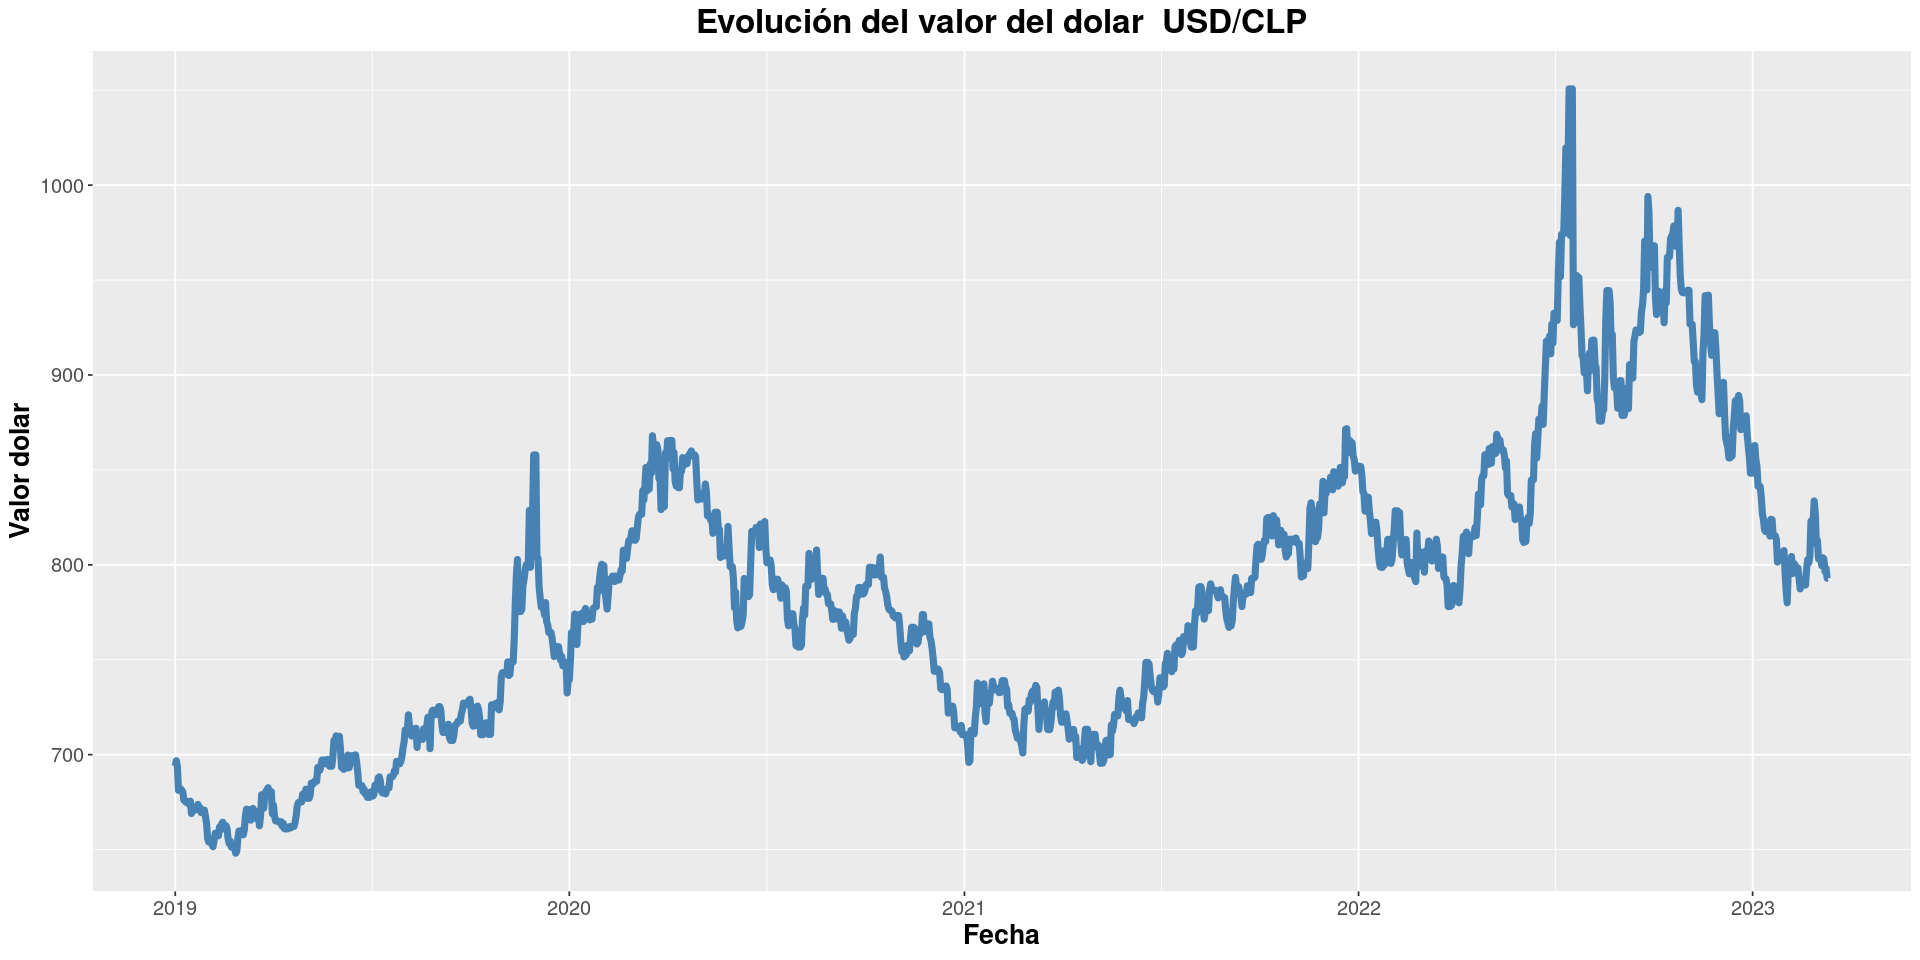

In [7]:
options(repr.plot.width = 16, repr.plot.height = 8)

p <- ggplot(usd_ts, aes(x = Date, y = Price)) +
  geom_line(color = "steelblue", linewidth = 2) +
  ggtitle("Evolución del valor del dolar  USD/CLP") +
  xlab("Fecha") +
  ylab("Valor dolar") +
  theme(axis.text = element_text(size=12),
    axis.title = element_text(size=16,face="bold"),
    plot.title = element_text(size=20, face="bold", hjust = 0.5))

p


## Actividad 1 - Análisis de anomalias puntuales

En la primera actividad buscaremos la presencia de anomalias puntuales. Para ellos usaremos la serie completa de datos, calcularemos la media y cuartiles.

Un grafico que es de gran utilidad para identificar outliers en un dataset es el boxplot o grafico de caja. El grafico de caja se construye calculando la media y los cuartiles Q1 y Q3. En la siguiente imagen se muestra los diferentes componentes de un grafico de caja.

![texto alternativo](https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png)

Calculamos la mediana y los minimo y maximo del analisis caja. Todo valor que se encuentre por debajo del minimo y por sobre el maximo son consideradors outliers.

In [8]:
bp_median = median(usd_ts$Price)
bp_min = quantile(usd_ts$Price, 0.25) - 1.5 * IQR(usd_ts$Price)
bp_max = quantile(usd_ts$Price, 0.75) + 1.5 * IQR(usd_ts$Price)

print("Análisis de boxplot")
print(paste("Mediana: ", bp_median))
print(paste("Minimo: ", bp_min))
print(paste("Maximo: ", bp_max))

[1] "Análisis de boxplot"
[1] "Mediana:  785.52"
[1] "Minimo:  565.404375"
[1] "Maximo:  982.459375"


Hacemos un grafico de caja con los datos de Precio

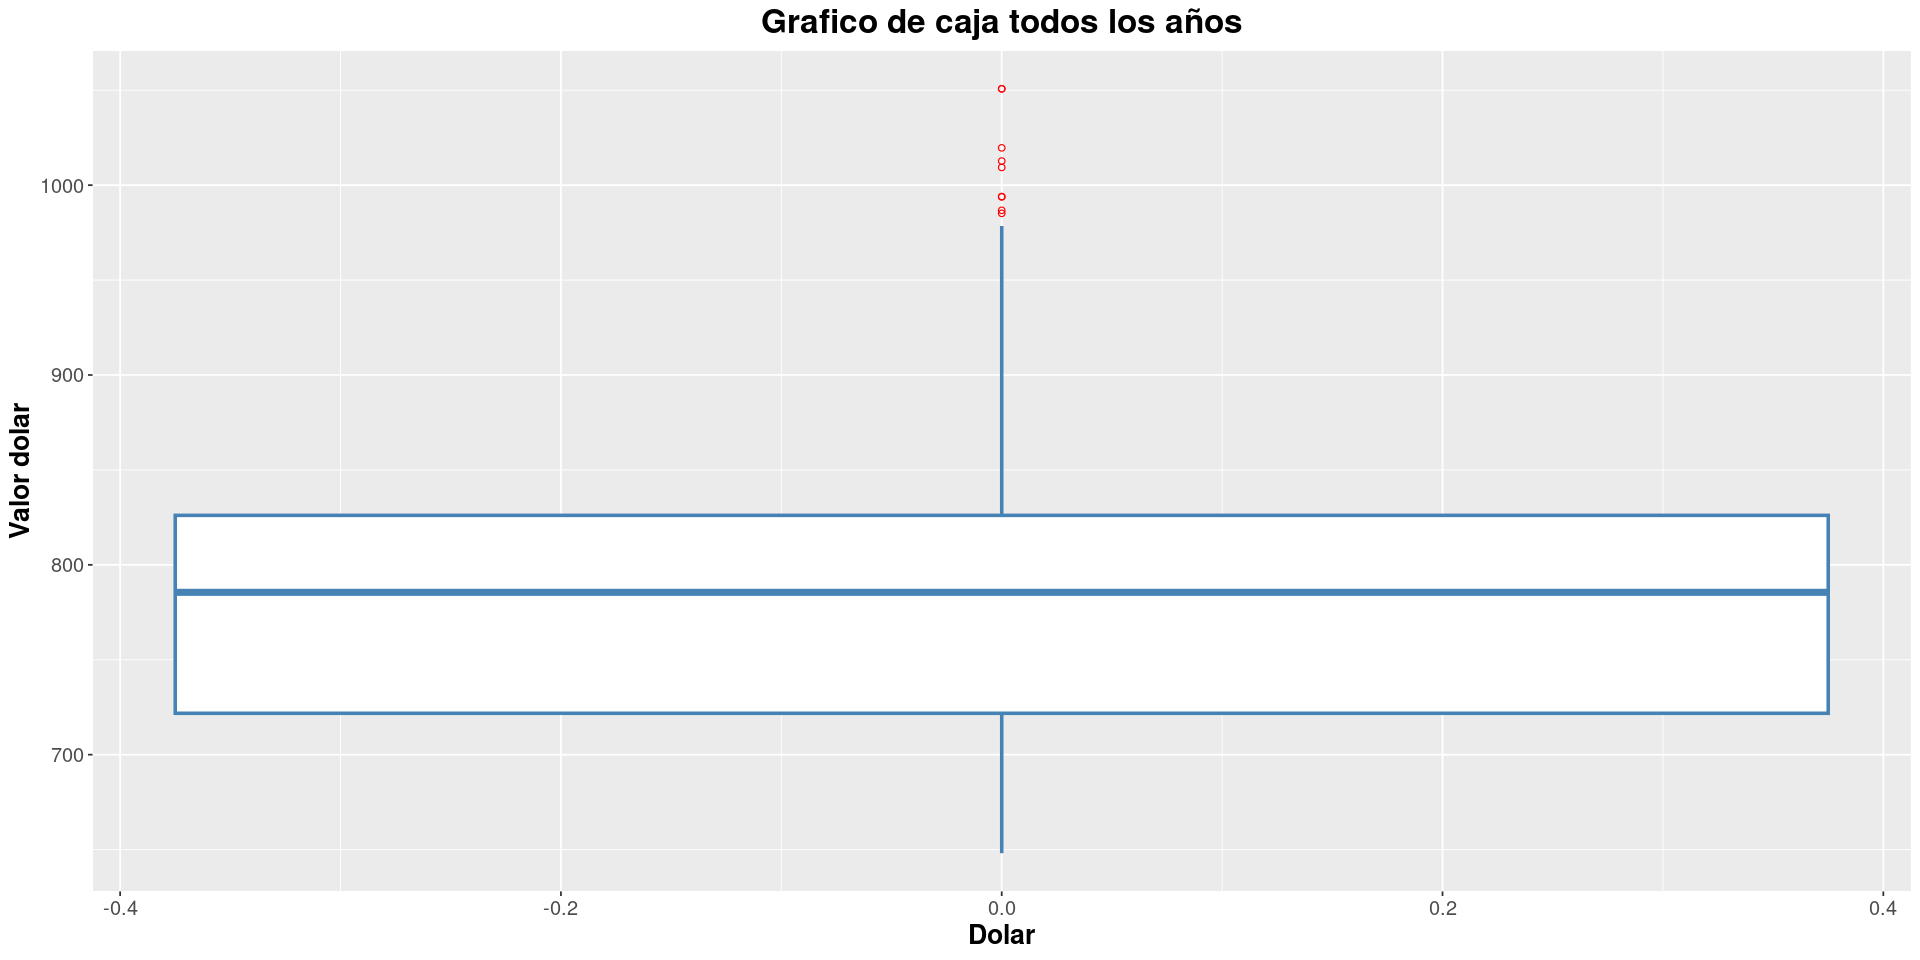

In [10]:
options(repr.plot.width = 16, repr.plot.height = 8)

bp <- ggplot(usd_ts, aes(y = Price)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 1, color = "steelblue", size = 1) +
  ggtitle("Grafico de caja todos los años") +
  xlab("Dolar") +
  ylab("Valor dolar") +
  theme(axis.text = element_text(size=12),
    axis.title = element_text(size=16,face="bold"),
    plot.title = element_text(size=20, face="bold", hjust = 0.5))

bp

Construimos la funcion is_outlier para identificar los valores que son outliers. Construimos el tibble usd_ts_outliers para almacenar los valores outliers

In [14]:
is_outlier <- function(x) {
  return(x < quantile(x, 0.25) - 1.5 * IQR(x) | x > quantile(x, 0.75) + 1.5 * IQR(x))
}

outliers <- is_outlier(usd_ts$Price)
usd_ts_outliers <- usd_ts[outliers, ]

cat( paste("Número de outliers: ", length(usd_ts_outliers$Price), "\n") )

cat("\nPrimeras 5 filas")
head(usd_ts_outliers)

cat("\nUltimas 5 filas")
tail(usd_ts_outliers)

Número de outliers:  9 

Primeras 5 filas

Price,Date
<dbl>,<date>
986.75,2022-10-24
985.16,2022-09-27
994.01,2022-09-26
1050.75,2022-07-18
1050.75,2022-07-15
1009.33,2022-07-14



Ultimas 5 filas

Price,Date
<dbl>,<date>
1050.75,2022-07-18
1050.75,2022-07-15
1009.33,2022-07-14
1012.70,2022-07-13
1019.65,2022-07-12
993.80,2022-07-11


Recuperamos el grafico de la evolucion del valor del dolar y marcamos los outliers usando circulos de color rojo

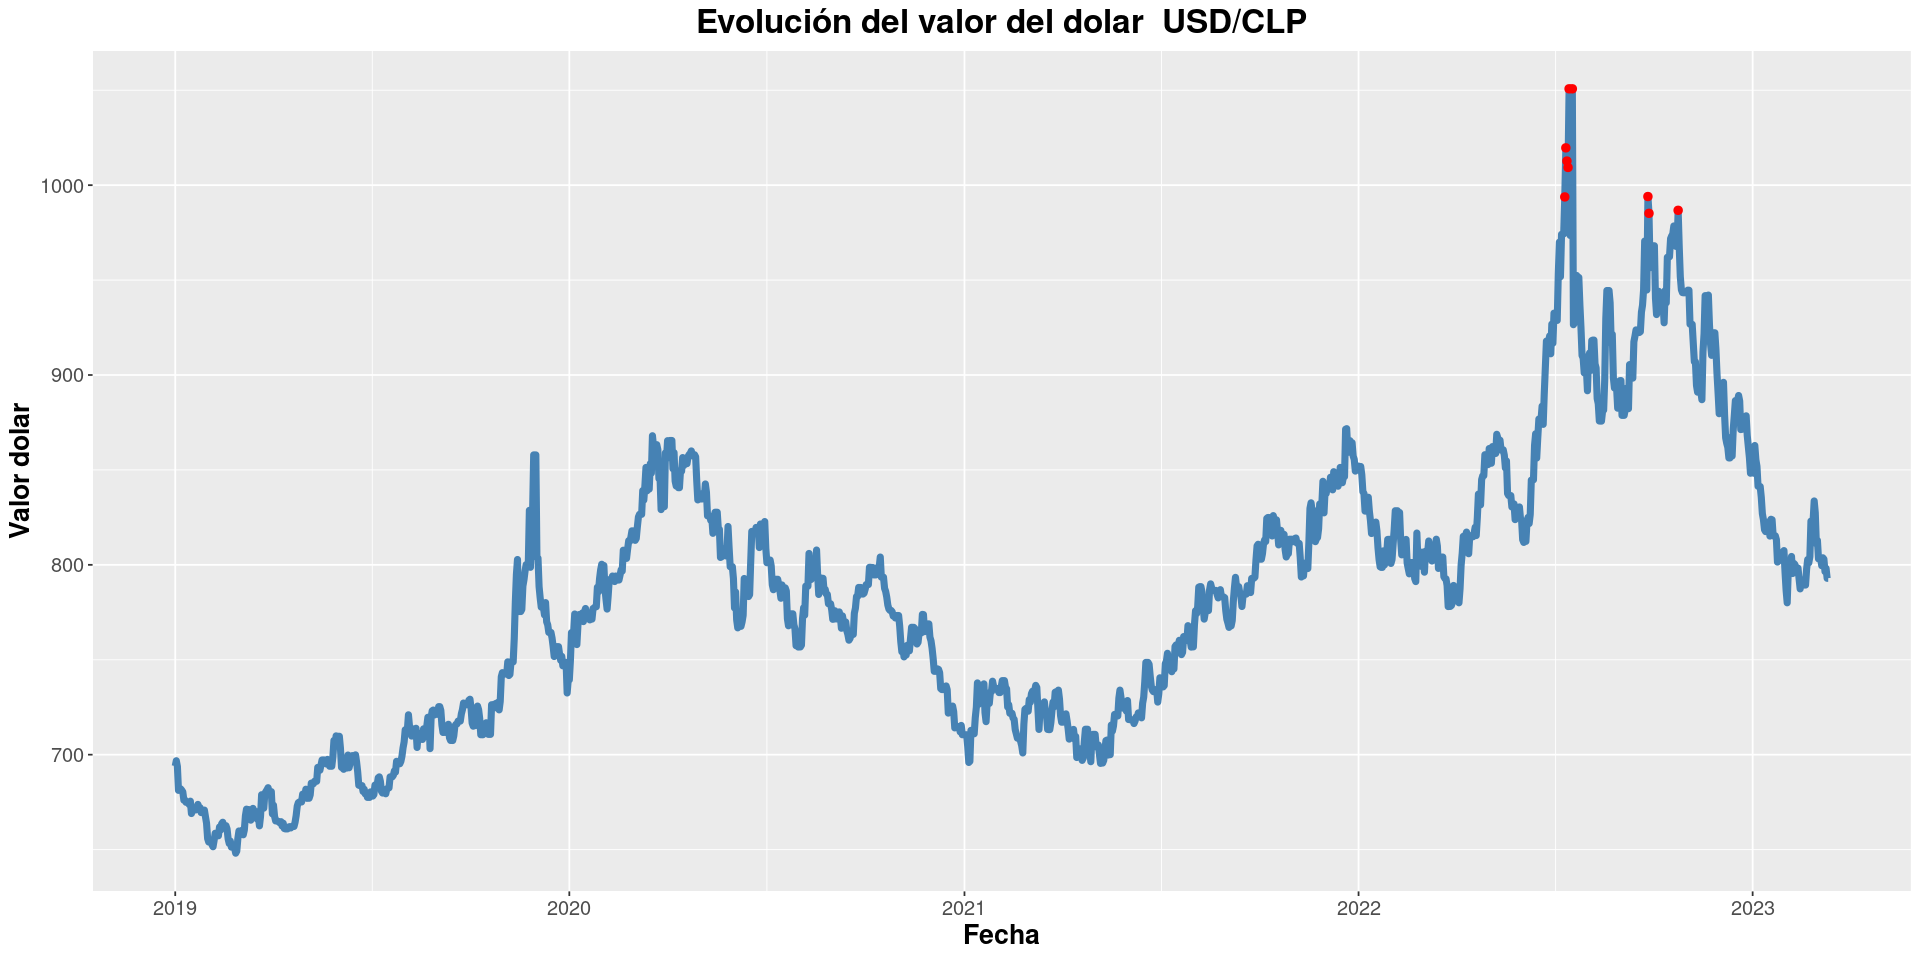

In [15]:
p + geom_point(data=usd_ts_outliers, aes(x = Date, y = Price), color='red', size=2)

## Pregunta 1

Describa algún caso de negocio en donde sea útil el boxplot de anomalías puntuales realizado para obtener outliers. ¿Que limitaciones observa?



---



## Actividad 2 - Análisis de anomalias contextuales

En la segunda actividad buscaremos la presencia de anomalias contextuales. Una manera simple es agrupar los datos por año y hacer un análisis de outliers en cada año.

Usaremos el grafico de cajas nuevamente.

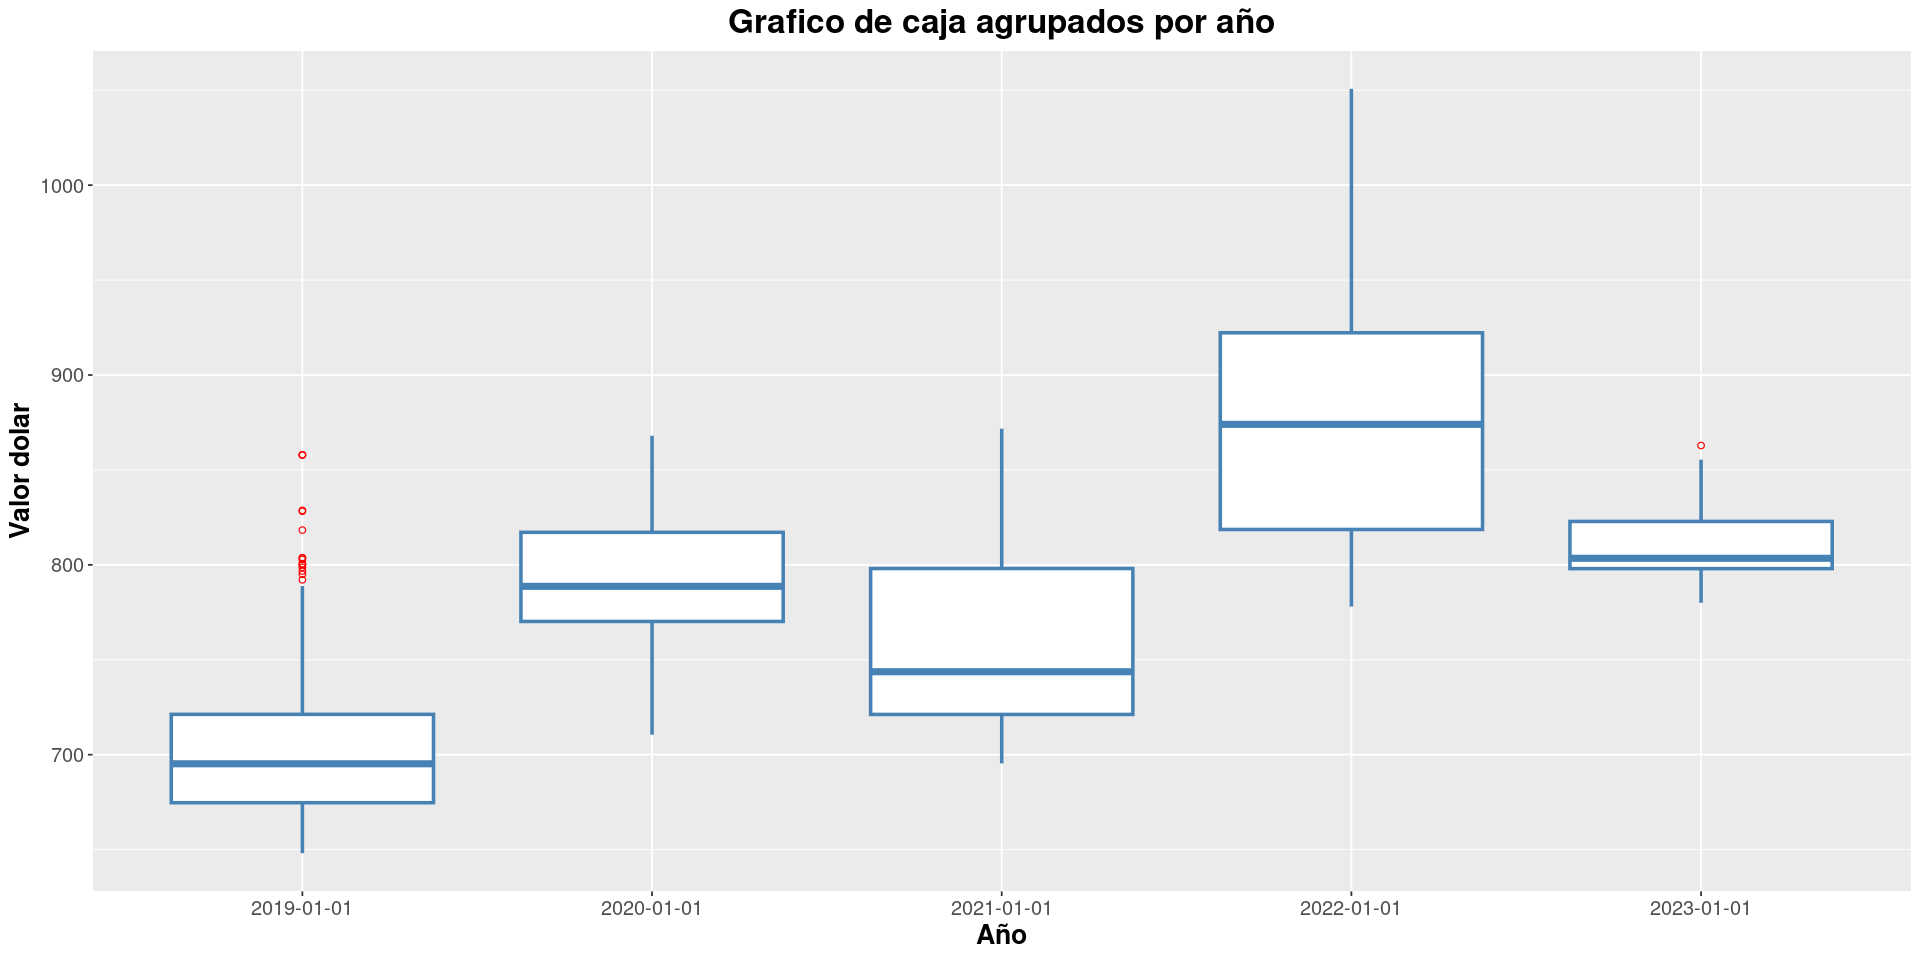

In [16]:
options(repr.plot.width = 16, repr.plot.height = 8)

usd_ts %>% ggplot(aes(x = cut(Date, breaks="year"), y = Price)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 1, color='steelblue', size=1) +
  ggtitle("Grafico de caja agrupados por año") +
  xlab("Año") +
  ylab("Valor dolar") +
  theme(axis.text = element_text(size=12),
    axis.title = element_text(size=16,face="bold"),
    plot.title = element_text(size=20, face="bold", hjust = 0.5))

In [17]:
usd_ts %>%
   group_by(year = format(Date, "%Y")) %>%
   summarise(median = median(Price))

year,median
<chr>,<dbl>
2019,695.200
2020,788.675
2021,743.690
2022,874.000
2023,803.450


En el grafico de caja notamos que los outliers o  valores atípicos se concentran en el 2019 y 2022. Usaremos la función is_outlier para recuperar los valores que son outliers.

In [18]:
is_outlier <- function(x) {
  return(x < quantile(x, 0.25) - 1.5 * IQR(x) | x > quantile(x, 0.75) + 1.5 * IQR(x))
}

usd_ts_outliers <- usd_ts %>%
  group_by(year = format(Date, "%Y")) %>%
  group_modify(~ .x[is_outlier(.x$Price),] )

print( paste("Número de outliers: ", length(usd_ts_outliers$Price)) )

usd_ts_outliers

[1] "Número de outliers:  17"


year,Price,Date
<chr>,<dbl>,<date>
2019,803.500,2019-12-03
2019,803.800,2019-12-02
2019,857.895,2019-12-01
2019,857.905,2019-11-30
2019,857.900,2019-11-29
2019,828.200,2019-11-28
2019,818.300,2019-11-27
2019,798.700,2019-11-26
2019,828.700,2019-11-25


Recuperamos el grafico de la evolucion del valor del dolar y marcamos los outliers usando circulos de color rojo

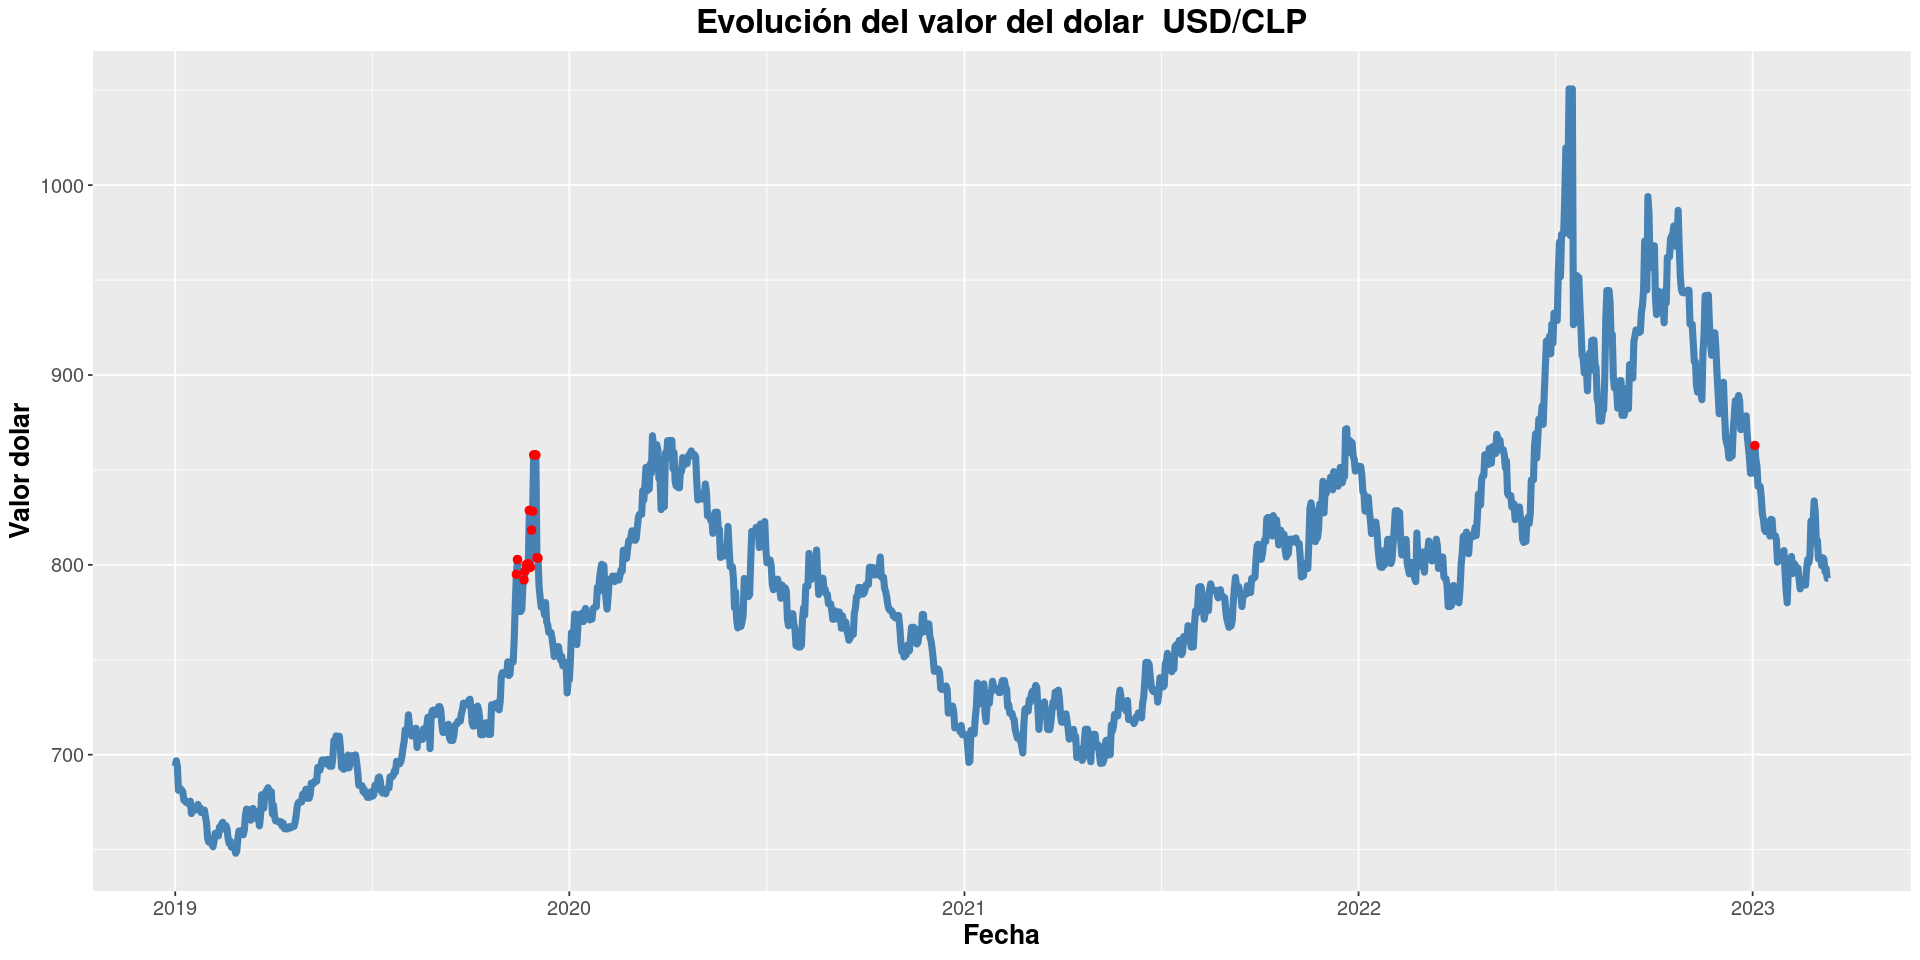

In [19]:
p + geom_point(data=usd_ts_outliers, aes(x = Date, y = Price), color='red', size=2)

## Pregunta 2

Describa algún caso de negocio en donde sea útil el boxplot de anomalías contextuales por año realizado para obtener outliers. ¿Que mejora hay respecto al caso anterior de la actividad 1?



---



---



## Actividad 3 - Analisis avanzado de anomalias colectivas y contextuales

En esta actividad usaremos la libreria anomalize para hacer analisis de anomalias en series de tiempo.

El paquete `anomalize` permite un flujo de trabajo ordenado para detectar anomalías en los datos. Las funciones principales son `time_decompose()`, `anomalize()` y `time_recompose()`. Cuando se combinan, es bastante simple descomponer series temporales, detectar anomalías y crear bandas que separen los datos "normales" de los datos anómalos a escala (es decir, para series temporales múltiples). La descomposición de series de tiempo se utiliza para eliminar tendencias y componentes estacionales a través de la función `time_decompose()` y los métodos incluyen la descomposición estacional de series de tiempo por Loess ("stl") y la descomposición estacional por medianas por partes ("twitter"). La función `anomalize()` implementa dos métodos para la detección de anomalías de residuos, incluido el uso de un rango de cuartil interno ("iqr") y una desviación generalizada extrema estudiantil ("gesd"). Estos métodos se basan en los utilizados en el paquete 'pronóstico' y el paquete 'Detección de anomalías' de Twitter. Consulte las funciones asociadas para obtener referencias específicas para estos métodos.

### Instalacion de librerias

In [21]:
#install.packages("anomalize", dependencies = TRUE, INSTALL_opts = '--no-lock', verbose = TRUE)
#devtools::install_github("business-science/anomalize")


### Cargar las librerias

Cargamos la libreria anomalize

In [22]:
library(anomalize) #tidy anomaly detectiom

Usamos la funcion `time_decompose()` para remover la estacionalidad y tendencia de la serie de tiempo, luego la funcion `anomalize()` para detectar los valores outliers, luego la funcion `time_recompose()` para volver a construir la serie de tiempo y finalmente la función `plot_anomalies()` para graficar la serie de tiempo y los outliers

Converting from tbl_df to tbl_time.
Auto-index message: index = Date

frequency = 7 days

trend = 91 days



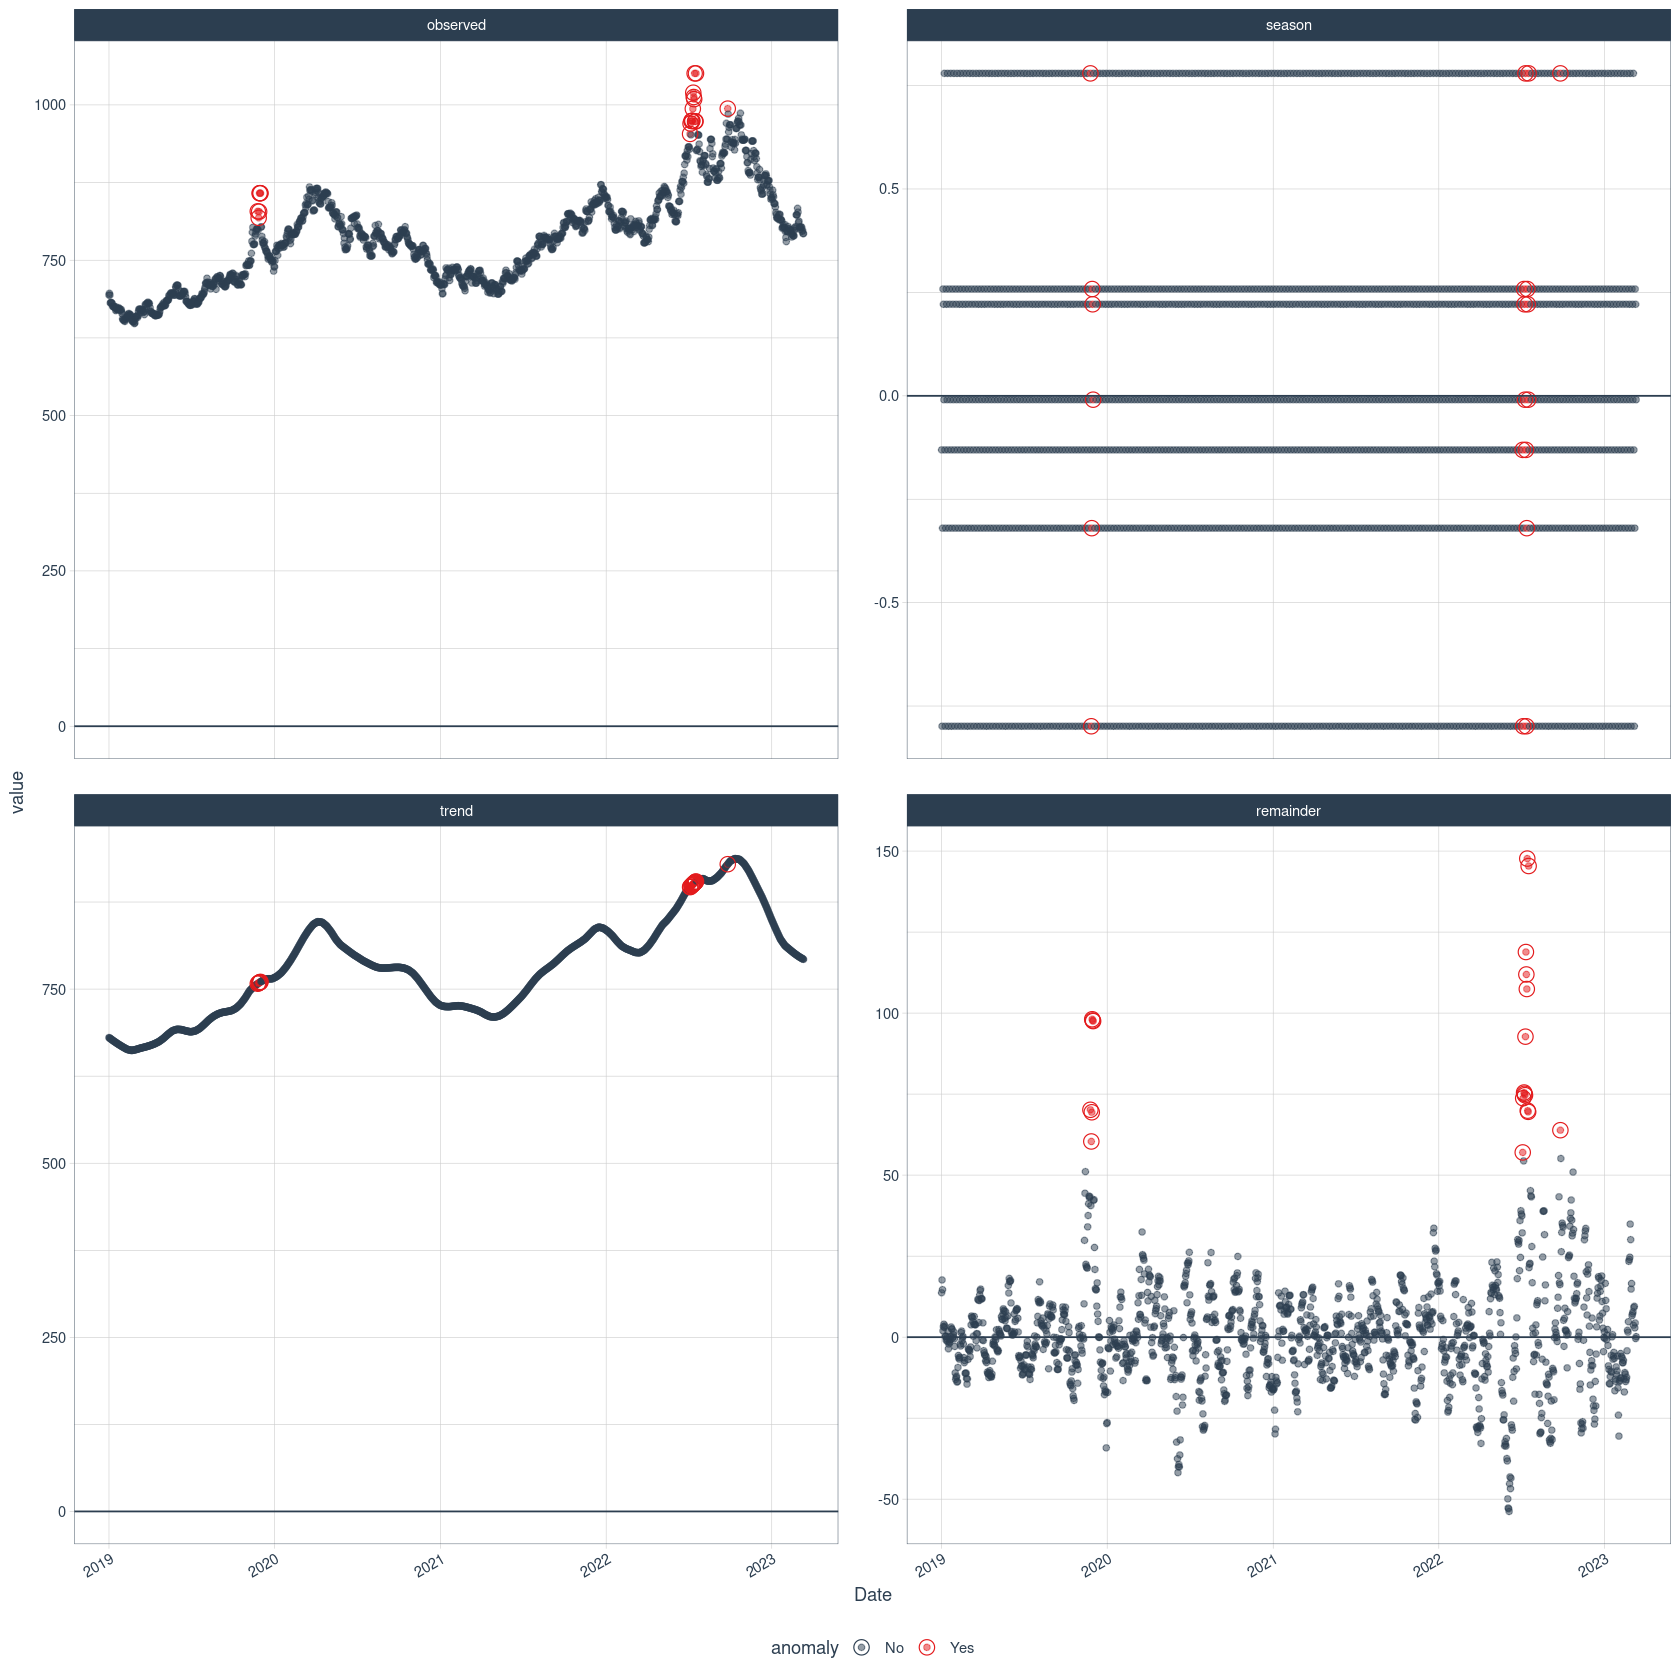

In [36]:
options(repr.plot.width = 14, repr.plot.height = 14)
usd_ts %>%
  map_df(rev) %>% # Revierte el orden del tibble
  time_decompose(Price) %>% # Genera nuevo tibble con las variables "observed" (Price), "season", "trend" y "reminder"
  anomalize(remainder) %>% # Calcula los límites fuera de los cuales "reminder" presenta outliers y los etiqueta en "anomaly"
  plot_anomaly_decomposition(ncol = 2, strip.position = "top", alpha_dots = 0.5)

Converting from tbl_df to tbl_time.
Auto-index message: index = Date

frequency = 7 days

trend = 91 days



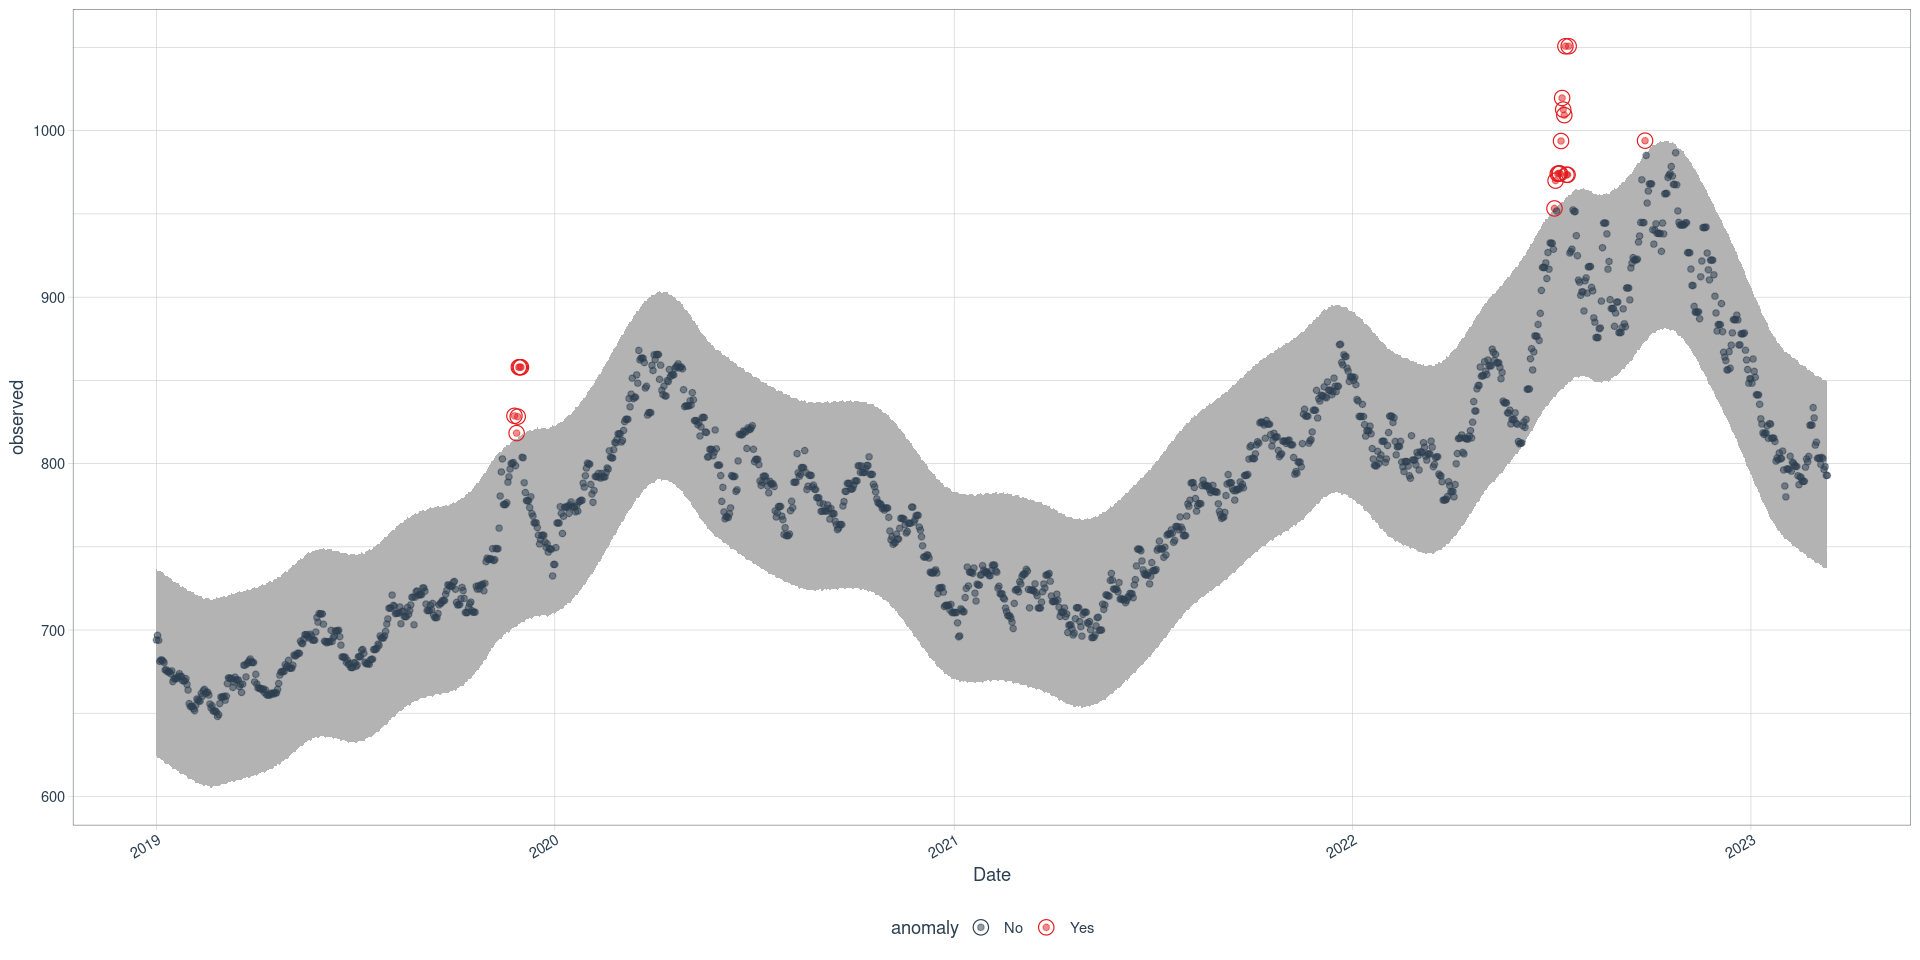

In [45]:
# Opciones para mostrar el gráfico de la serie de tiempo reconstituída
options(repr.plot.width = 16, repr.plot.height = 8)

usd_ts %>%
  map_df(rev) %>%
  time_decompose(target = Price, frequency = 7, trend = 91) %>% # Los valores de "frequency" y "trend" son los por defecto.
  anomalize(remainder) %>%
  time_recompose() %>% # Recompone la serie de tiempo con los límites para outliers desde el valor "season" + "trend"
  plot_anomalies(time_recomposed = TRUE, ncol = 3, alpha_dots = 0.5)

Las funciones `time_decompose()` y `anomalize()` permiten usar parametros para mejorar el analisis de la serie de tiempo y determinar de mejor manera los outliers.

Visite el siguiente link para mas info https://cran.r-project.org/web/packages/anomalize/vignettes/anomalize_methods.html

Converting from tbl_df to tbl_time.
Auto-index message: index = Date

frequency = 7 days

trend = 30 days



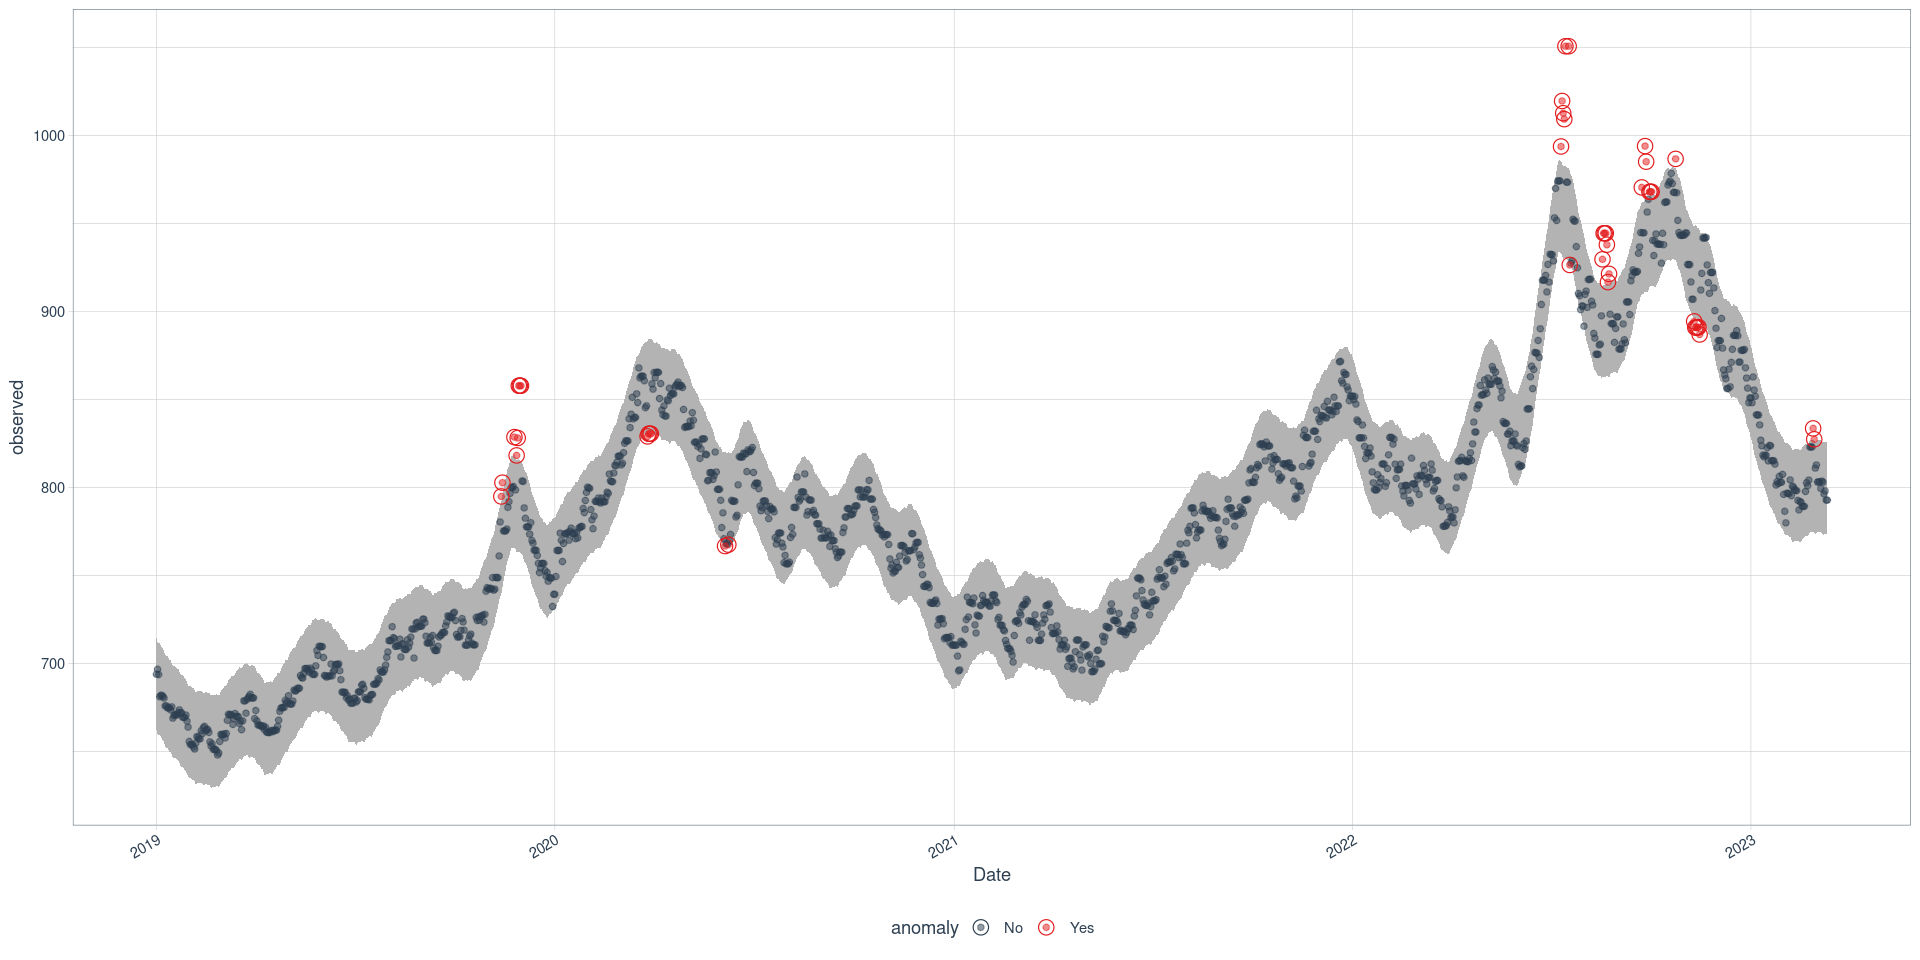

In [48]:
options(repr.plot.width = 16, repr.plot.height = 8)

usd_ts %>%
  time_decompose(Price, method = "stl", frequency = 7, trend = 30) %>% # Si disminuimos "trend" se disminuye el ancho de la envolvente
  anomalize(remainder, method = "gesd", alpha = 0.05, max_anoms = 0.2) %>%
  time_recompose() %>%
  plot_anomalies(time_recomposed = TRUE, ncol = 3, alpha_dots = 0.5)

# En escala de 1 mes o según la variabilidad de 30 días (15 días antes y 15 días después) estos son los valores outliers.

En caso que querramos recuperar los valores outliers encontrados por el metodo de anomalize, podemos usar la funcion filter() e imprimierlos en pantalla.

In [49]:
usd_ts %>%
  time_decompose(Price, method = "stl", frequency = 10, trend = 200) %>%
  anomalize(remainder, method = "gesd", alpha = 0.05, max_anoms = 0.2) %>%
  time_recompose() %>%
  filter(anomaly == 'Yes')

Converting from tbl_df to tbl_time.
Auto-index message: index = Date

frequency = 10 days

trend = 200 days



Date,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
2022-10-24,986.750,0.22979340,902.9569,83.56331,-67.69729,67.63735,Yes,835.4894,970.8240
2022-10-21,972.750,-0.27255327,903.8710,69.15156,-67.69729,67.63735,Yes,835.9012,971.2358
2022-10-20,978.500,-0.54748209,904.1378,74.90963,-67.69729,67.63735,Yes,835.8931,971.2277
2022-10-19,974.200,-0.05174937,904.4047,69.84705,-67.69729,67.63735,Yes,836.6557,971.9903
2022-10-18,973.250,-0.22580644,904.6716,68.80426,-67.69729,67.63735,Yes,836.7485,972.0831
2022-09-27,985.160,0.77776564,909.3792,75.00301,-67.69729,67.63735,Yes,842.4597,977.7943
2022-09-26,994.010,0.20748553,909.4967,84.30581,-67.69729,67.63735,Yes,842.0069,977.3415
2022-07-18,1050.750,0.20748553,885.1711,165.37144,-67.69729,67.63735,Yes,817.6813,953.0159
2022-07-17,973.510,0.51267360,884.5683,88.42899,-67.69729,67.63735,Yes,817.3837,952.7184


## Pregunta 3

Describa algún caso de negocio en donde sea util esta descomposición de series de tiempo para la detección de anomalias. ¿Que nos permite ajustar la tendencia y frecuencia?




---



---



# EDA


Aqui revisaremos una herramienta de Exploratory Data Analysis

In [39]:
library(readxl)

In [40]:
dataURL = 'https://clasesmlds.s3.amazonaws.com/data/proyecto_1_datos_fuga.xls'
dataFile = 'Proyecto_1_Base_analisis_de_fuga.xls'
download.file(url = dataURL, destfile=dataFile)
dataset <- read_xls(dataFile)
cat("\nPrimeras 5 filas")
head(dataset)

New names:
• `` -> `...1`



Primeras 5 filas

...1,Sexo,Edad,Casado,Numero Dependientes,Recomendaciones realizadas,Meses como Cliente,Plan,Cargo Mensual LLamadas,Multiples lineas,⋯,Usa Streaming Musica,Plan Ilimitado Datos,Tipo Contrato,Cobro Mensual,Historico de Devoluciones,Historico Cargos extra datos,Historico Cargos Llamadas,Historico Cobro Acumulado,Fugado,Causa Fuga
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0,Mujer,37,Si,0,2,9,Ninguno,22042.8,No,⋯,No,Si,Anual,34112,0.0,0,198385.2,506901.2,No,NA
1,Hombre,46,No,0,0,9,Ninguno,5558.8,Si,⋯,Si,No,Mensual,-2080,19931.6,5200,50029.2,317345.6,No,NA
2,Hombre,50,No,0,0,4,Plan E,17498.0,No,⋯,No,Si,Mensual,38428,0.0,0,69992.0,216034.0,Si,Mejor la Competencia
3,Hombre,78,Si,0,1,13,Plan D,14466.4,No,⋯,No,Si,Mensual,50960,0.0,0,188063.2,831745.2,Si,Disconforme
4,Mujer,75,Si,0,3,3,Ninguno,3837.6,No,⋯,No,Si,Mensual,43628,0.0,0,11512.8,150560.8,Si,Disconforme
5,Mujer,23,No,3,0,9,Plan E,8720.4,No,⋯,Si,Si,Mensual,36088,0.0,0,78483.6,375637.6,No,NA


In [50]:
#install.packages("DataExplorer", dependencies = TRUE, INSTALL_opts = '--no-lock', verbose = TRUE)

In [43]:
library(DataExplorer)

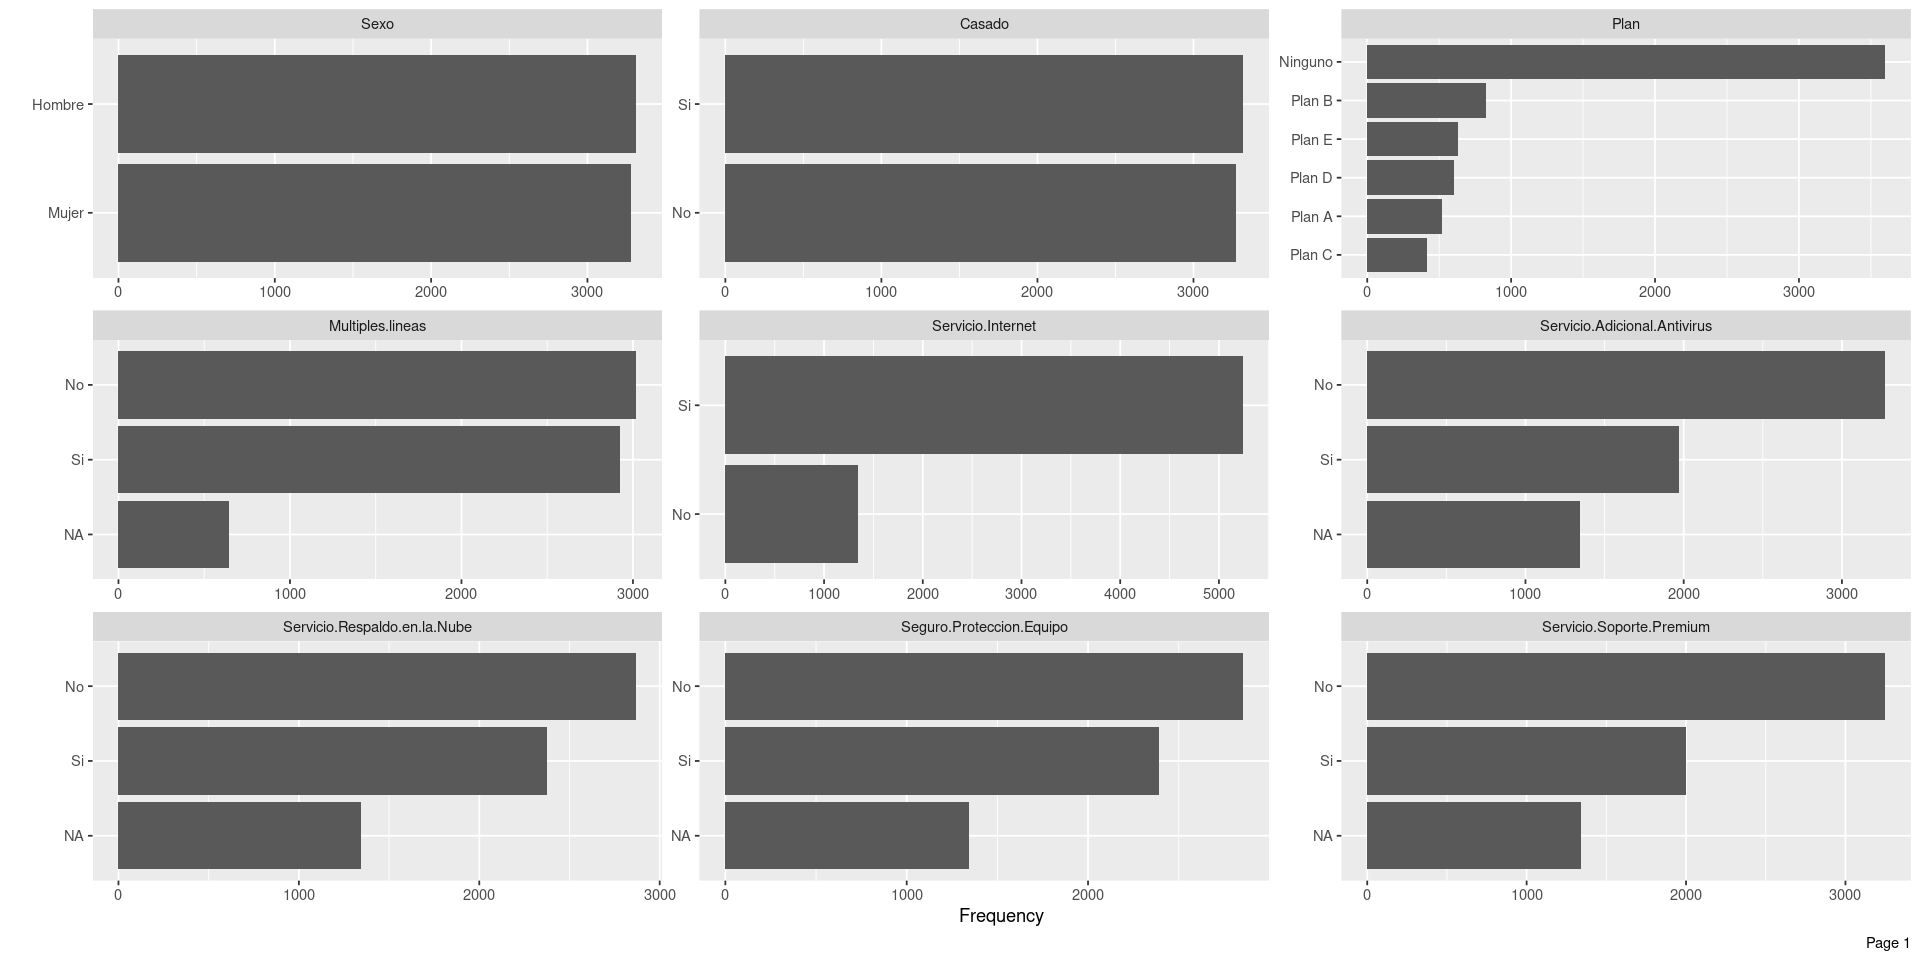

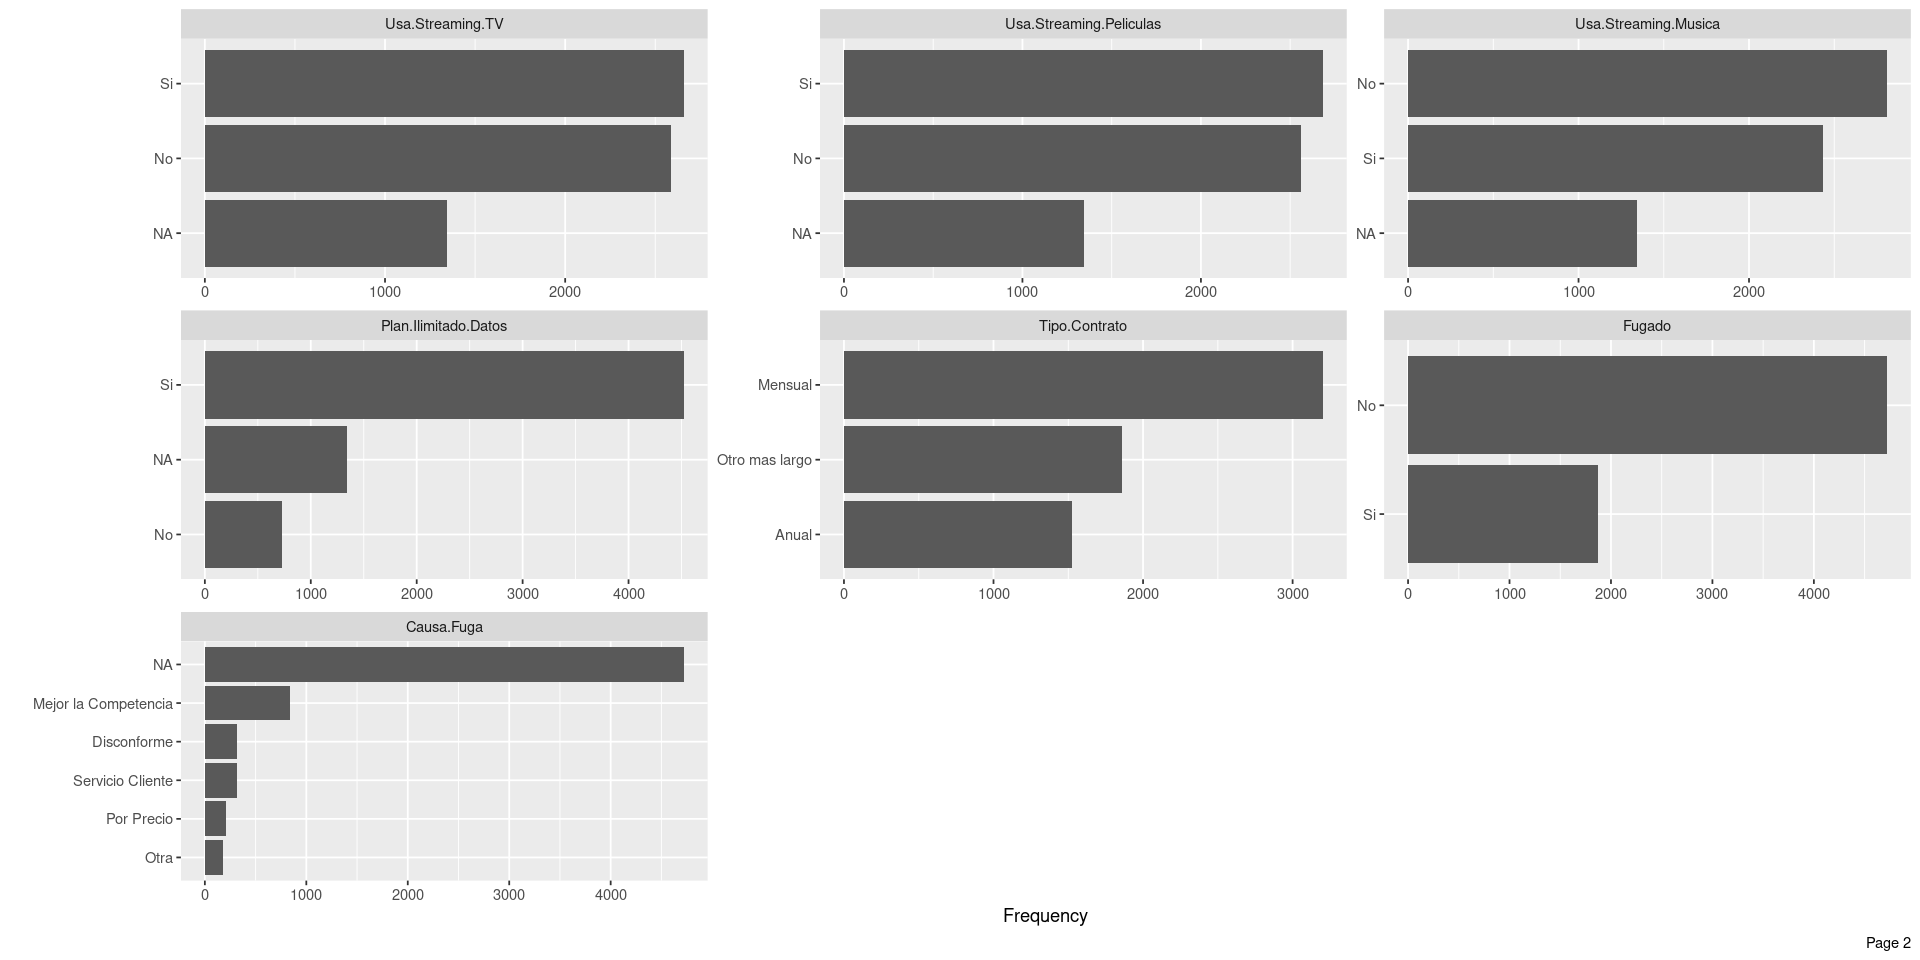

In [44]:
plot_bar(dataset)

In [51]:
introduce(dataset)

rows,columns,discrete_columns,continuous_columns,all_missing_columns,total_missing_values,complete_rows,total_observations,memory_usage
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
6589,28,16,12,0,18104,1586,184492,1485328


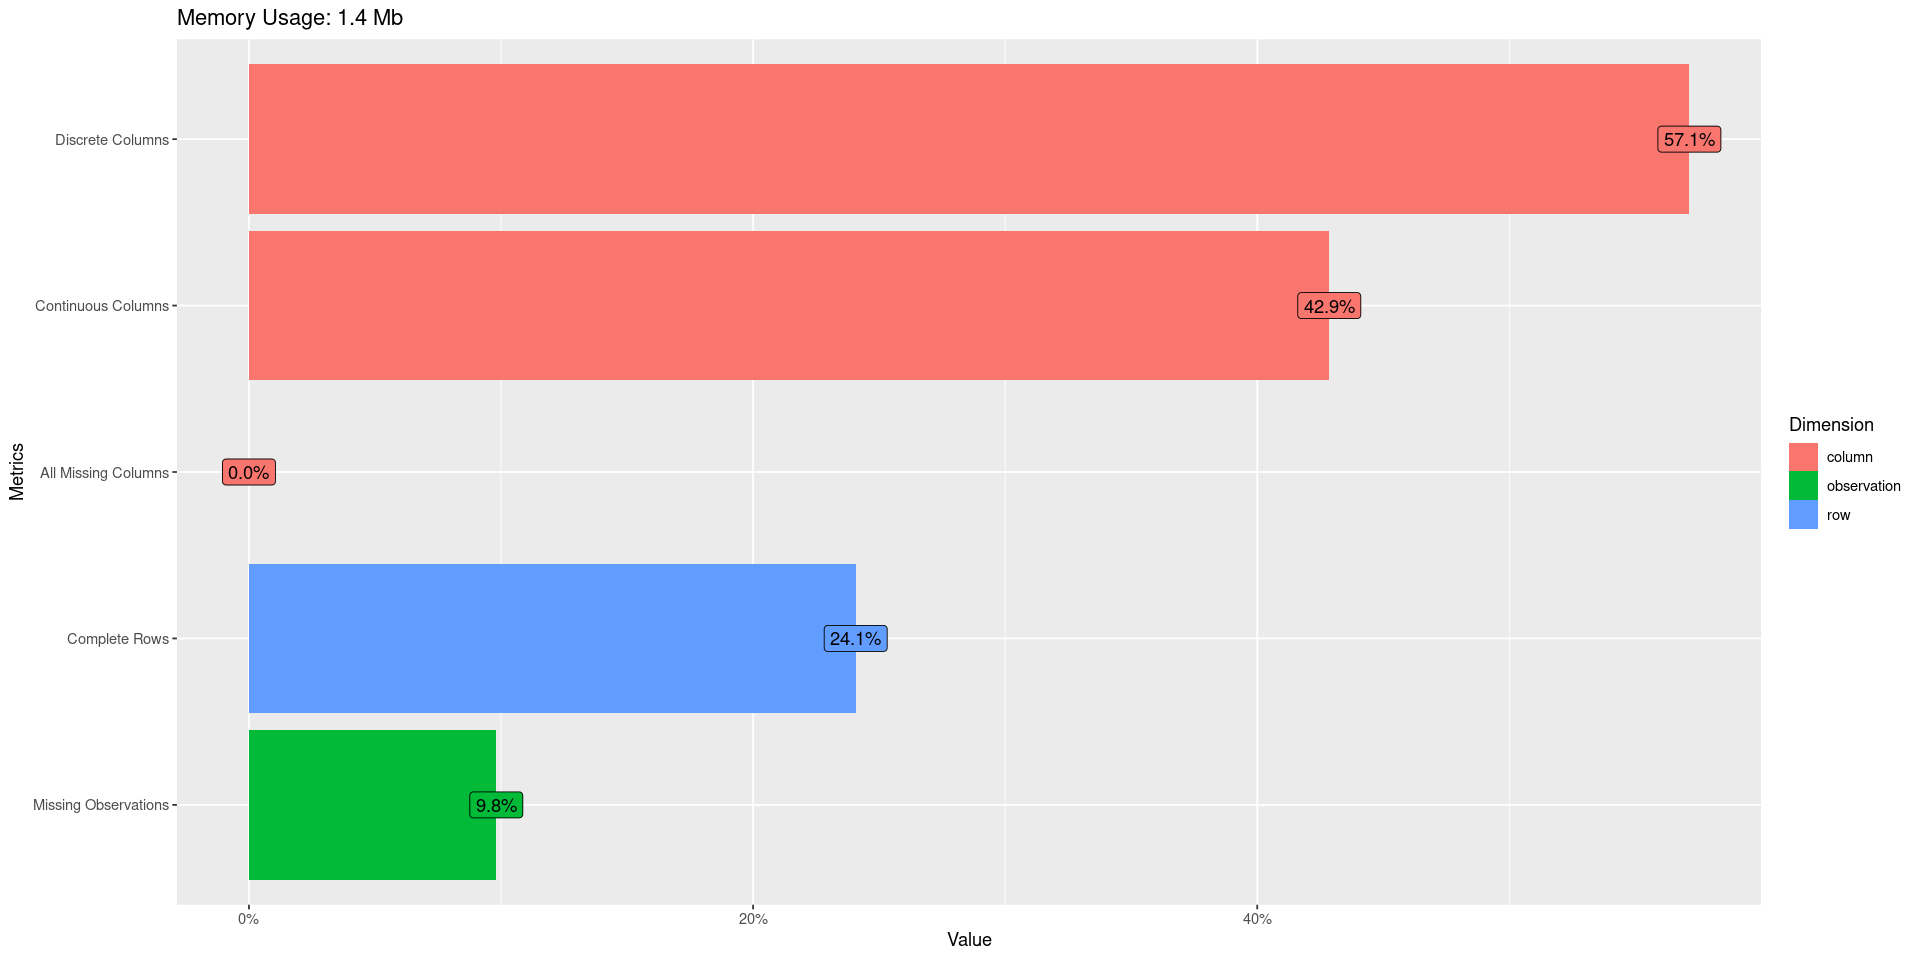

In [52]:
plot_intro(dataset)

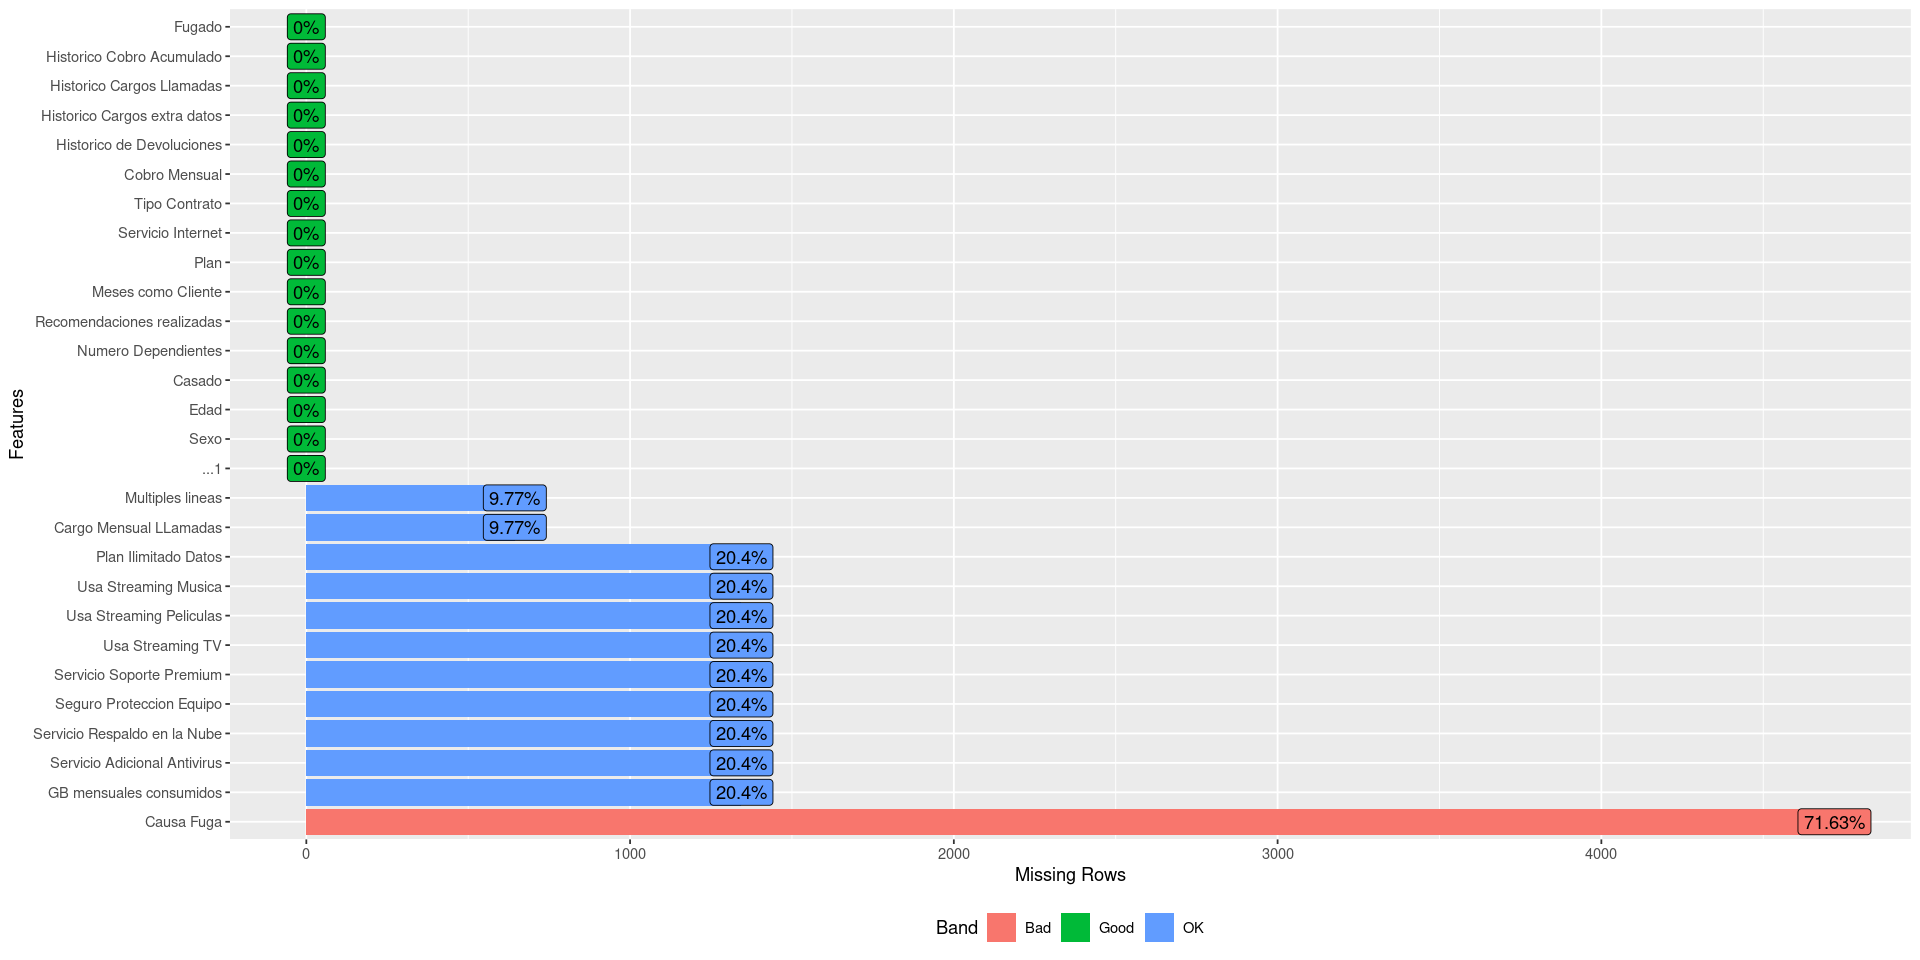

In [53]:
plot_missing(dataset)

## Pregunta 4

Que utilidad observa en esta herramienta? Para que casos de negocio podria ser interesante su uso?